<a href="https://colab.research.google.com/github/kovacsanna77/szakdolgozat/blob/main/BERT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# paramters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Fake news/dataset_ent_sum.csv", index_col=0)
df.head(10)

,title,author,url,date,year,month,day,regions,tags,summary,og_link,original_lang,label,summary_nltk,entities
0,There is a Western pressure campaign against R...,na,https://euvsdisinfo.eu/report/western-pressure...,2020-02-06,2020.0,2.0,6.0,"France, US, Russia","Russia Today (RT), Emmanuel Macron, Mainstream...",Western countries are carrying out a pressure ...,https://mundo.sputniknews.com/politica/2020020...,Spanish,1,Western countries are carrying out a pressure ...,"Emmanuel Macron, French, RT, Russian, Sputnik, US"
1,World's most expensive cities: New York and Si...,Malu Cursino,https://bbc.com/news/world-63825214,2022-12-01 00:00:00,2022.0,12.0,1.0,NaN,War in Ukraine,The world's most expensive cities are jointly ...,https://bbc.com/news/world-63825214,en,0,1 = New York 1 = Singapore 3 = Tel Aviv 4 = Ho...,"10 - earlier this year, 4, Algiers, Almaty, Ch..."
2,Ukraine: Bath woman says visa scheme an 'absol...,NaN,https://bbc.com/news/uk-england-somerset-61113570,2022-04-15 00:00:00,2022.0,4.0,15.0,NaN,War in Ukraine,A woman who has prepared her home for the arri...,https://bbc.com/news/uk-england-somerset-61113570,en,0,Five adults and two children have arrived in B...,"BANES, Bath and North East Somerset, Dine Rome..."
3,Swedes cheer end of long wait to join Nato,Maddy Savage,https://bbc.com/news/world-europe-68509301,2024-03-08 00:00:00,2024.0,3.0,8.0,NaN,War in Ukraine,"Almost two years after applying to join Nato, ...",https://bbc.com/news/world-europe-68509301,en,0,"In early 2022, the country's then Social Democ...","16, Almost two years, BBC, Friday, Joe Biden, ..."
4,Misinformation spreads in China on ‘civil war’...,Kerry Allen,https://bbc.com/news/world-us-canada-68185317,2024-02-02 00:00:00,2024.0,2.0,2.0,NaN,War in Ukraine,Amid the escalating border standoff between Te...,https://bbc.com/news/world-us-canada-68185317,en,0,"A Voice of America journalist Wenhao, who spec...","Abbott, China, Chinese, Florida, Friday, Lone ..."
5,The parole system is broken,Eddie Conway,https://therealnews.com/the-parole-system-is-b...,2021-04-13 00:00:00,2021.0,4.0,13.0,NaN,War in Ukraine,Prisoners are often excluded from discussions ...,https://therealnews.com/the-parole-system-is-b...,English,0,This privatization as well as the racialized a...,America
6,Sputnik V is world's first coronavirus vaccine...,na,https://euvsdisinfo.eu/report/sputnik-v-is-wor...,2021-01-14,2021.0,1.0,14.0,Russia,"Sputnik V, coronavirus, vaccination, Russian s...","In August, Russia became the first country to ...",https://sputniknews.com/world/2021011410817655...,English,1,"In August, Russia became the first country to ...","August, COVID-19, Russia, Sputnik V."
7,Protests and revolutions in former Soviet coun...,na,https://euvsdisinfo.eu/report/protests-and-rev...,2020-11-02,2020.0,11.0,2.0,"Kyrgyzstan, Azerbaijan, Armenia, Moldova, Geor...","West, Anti-Russian, Encircling Russia, Conspir...",And now our country’s opponents are transferri...,https://ukraina.ru/exclusive/20201102/10294285...,Russian,1,And now our country’s opponents are transferri...,"Belarus, Central Asia, Moldova, Transcaucasia,..."
8,US and EU coordinate colour revolutions to des...,na,https://euvsdisinfo.eu/report/us-and-eu-coordi...,2021-02-25,2021.0,2.0,25.0,"Russia, US, EU, Ukraine","Colour revolutions, Conspiracy theory, Encircl...",Russia usually displays infinite patience and ...,https://arabic.rt.com/press/1205866-%D9%84%D8%...,Arabic,1,Russia usually displays infinite patience and ...,"2014, Crimea, Russia, Russian, Ukraine, West, ..."
9,Polish Strategy of National Security was writt...,na,https://euvsdisinfo.eu/report/the-polish-strat...,2020-04-13,2020.0,4.0,13.0,"Poland, US, Russia","security threat, Anti-Russian, Puppets, US pre...",It is not a secret that important Polish docum...,https://pl.sputniknews.com/pisza-dla-nas/20200...,Polish,1,It is not a secret that important Polish docum...,"American, China, Polish, Russia, USA, the Unit..."


In [5]:
! pip install fast_ml --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 894.5 kB/s eta 0:00:00


In [6]:
df = df.dropna(subset = ['summary_nltk'])
df = df.dropna(subset = ['date'])

In [7]:
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
#Load up our stop words
stop_words = stopwords.words('english')

import re
def clean_txt(text):
    text = re.sub("'", "", text)
    text = re.sub(r"<[^>]+>", "", text)

    return text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
df['summary_nltk'] = df['summary_nltk'].str.replace(r"[\"'!@#$%^&*(){}[\]:;,<.>?/~`_+=|-]", '', regex=True)

In [9]:
df['summary_nltk'] = df['summary_nltk'].apply(clean_txt)

In [10]:
df.head()

,title,author,url,date,year,month,day,regions,tags,summary,og_link,original_lang,label,summary_nltk,entities
0,There is a Western pressure campaign against R...,na,https://euvsdisinfo.eu/report/western-pressure...,2020-02-06,2020.0,2.0,6.0,"France, US, Russia","Russia Today (RT), Emmanuel Macron, Mainstream...",Western countries are carrying out a pressure ...,https://mundo.sputniknews.com/politica/2020020...,Spanish,1,Western countries are carrying out a pressure ...,"Emmanuel Macron, French, RT, Russian, Sputnik, US"
1,World's most expensive cities: New York and Si...,Malu Cursino,https://bbc.com/news/world-63825214,2022-12-01 00:00:00,2022.0,12.0,1.0,NaN,War in Ukraine,The world's most expensive cities are jointly ...,https://bbc.com/news/world-63825214,en,0,1 New York 1 Singapore 3 Tel Aviv 4 Hong K...,"10 - earlier this year, 4, Algiers, Almaty, Ch..."
2,Ukraine: Bath woman says visa scheme an 'absol...,NaN,https://bbc.com/news/uk-england-somerset-61113570,2022-04-15 00:00:00,2022.0,4.0,15.0,NaN,War in Ukraine,A woman who has prepared her home for the arri...,https://bbc.com/news/uk-england-somerset-61113570,en,0,Five adults and two children have arrived in B...,"BANES, Bath and North East Somerset, Dine Rome..."
3,Swedes cheer end of long wait to join Nato,Maddy Savage,https://bbc.com/news/world-europe-68509301,2024-03-08 00:00:00,2024.0,3.0,8.0,NaN,War in Ukraine,"Almost two years after applying to join Nato, ...",https://bbc.com/news/world-europe-68509301,en,0,In early 2022 the countrys then Social Democra...,"16, Almost two years, BBC, Friday, Joe Biden, ..."
4,Misinformation spreads in China on ‘civil war’...,Kerry Allen,https://bbc.com/news/world-us-canada-68185317,2024-02-02 00:00:00,2024.0,2.0,2.0,NaN,War in Ukraine,Amid the escalating border standoff between Te...,https://bbc.com/news/world-us-canada-68185317,en,0,A Voice of America journalist Wenhao who speci...,"Abbott, China, Chinese, Florida, Friday, Lone ..."


In [11]:

train_text, temp_text, train_labels, temp_labels = train_test_split(df['summary_nltk'], df['label'],
                                                                    random_state=42,
                                                                    test_size=0.4,
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=42,
                                                                test_size=0.1,
                                                                stratify=temp_labels)

In [12]:

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:

# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [14]:

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


<Axes: >

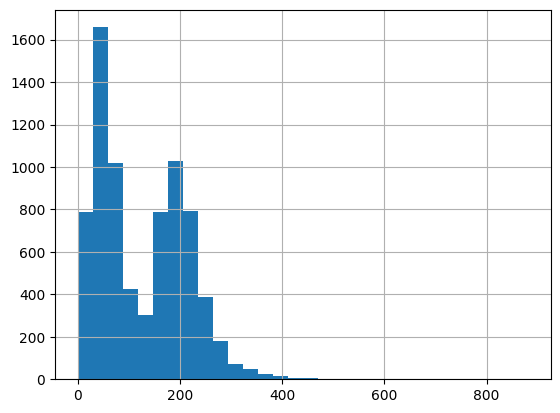

In [15]:

# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)


In [16]:
max_seq_len = 25

In [17]:

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [19]:

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = RandomSampler(test_data)

# dataLoader for train set
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)



# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [20]:

# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [21]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #self.fc3 = nn.Linear(128,2)
      self.sigmoid= nn.Sigmoid()




    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply  activation
      x = self.sigmoid(x)

      return x


In [22]:
import torch.nn as nn

class BERT_LSTM_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_LSTM_Arch, self).__init__()
        self.bert = bert

        # LSTM layer
        self.lstm = nn.LSTM(input_size=768, hidden_size=256, num_layers=1, batch_first=True, bidirectional=True)

        # Dropout layer
        self.dropout = nn.Dropout(0.25)

        # Relu activation function
        self.relu = nn.ReLU()
        self.sigmoid= nn.Sigmoid()
        self.fc2 = nn.Linear(512, 256)
        # Fully connected layer
        self.fc = nn.Linear(256, 2)

    def forward(self, sent_id, mask):
        # Passing the inputs to the model
        outputs = self.bert(sent_id, attention_mask=mask, return_dict=True)
        sequence_output = outputs.last_hidden_state

        # LSTM over the sequence
        lstm_output, (hidden, cell) = self.lstm(sequence_output)

        # Using the hidden state of the last time step
        lstm_output = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        x = self.fc2(lstm_output)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc(x)
        x = self.sigmoid(x)

        return x


In [23]:

# pass the pre-trained BERT to our define architecture
model = BERT_LSTM_Arch(bert)


# push the model to GPU
model = model.to(device)


In [24]:
from transformers import AdamW
from torch.optim.lr_scheduler import StepLR

# Assuming model is already defined
optimizer = AdamW(model.parameters(), lr=0.00005)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:

from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.98333333 1.01724138]


In [26]:

# convert class weights to tensor
weights = torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy =  nn.CrossEntropyLoss(weight = weights)


# number of training epochs
epochs = 10
#early stopping ? más aktivációs fgv

In [27]:

# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds


In [28]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from torch.nn.functional import softmax

def evaluate():
    print("\nEvaluating...")


    model.eval()

    total_loss = 0
    total_correct = 0
    total_preds = []
    predictions = []  # This will store all predictions as flat list
    true_labels = []  # This will store all true labels as flat list

    # Iterate over batches
    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # Push the batch to gpu
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        # Deactivate autograd
        with torch.no_grad():
            # Model predictions
            preds = model(sent_id, mask)
            pred_labels = preds.argmax(dim=1)

            # Compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

            # Collect predictions and labels for metric calculation
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            preds = preds.detach().cpu().numpy()
            total_correct += (pred_labels == labels).sum().item()

            total_preds.append(preds)

    # Compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)
    total_accuracy = total_correct / len(val_dataloader.dataset)

    # Calculate metrics
    precision = precision_score(true_labels, predictions, average='binary')
    recall = recall_score(true_labels, predictions, average='binary')
    f1 = f1_score(true_labels, predictions, average='binary')
    roc_auc = roc_auc_score(true_labels, predictions)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_accuracy, precision, recall, f1, roc_auc, total_preds


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
# function for evaluating the model
def evaluate_():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []
  total_correct = 0

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)
      pred_labels = preds.argmax(dim=1)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_correct += (pred_labels == labels).sum().item()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  total_accuracy = total_correct / len(val_dataloader.dataset)

  # reshape the predictions in form of (number of samples, no. of classes)

  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_accuracy, total_preds

In [30]:

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
valid_accuracies = []
prec = []
recalls =[]
f1scores = []
rocauc = []
#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, valid_acc, precision, recall, f1, roc_auc, _ = evaluate()

    scheduler.step()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_lstm.pt')


    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    prec.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    rocauc.append(roc_auc)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}, \n validation accuracy: {valid_acc:.3f}')
    print(f'Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}, ROC-AUC: {roc_auc:.3f}')



 Epoch 1 / 10
  Batch    50  of    236.
  Batch   100  of    236.
  Batch   150  of    236.
  Batch   200  of    236.

Evaluating...
  Batch    50  of    142.
  Batch   100  of    142.

Training Loss: 0.546
Validation Loss: 0.429, 
 validation accuracy: 0.878
Precision: 0.837, Recall: 0.934, F1 Score: 0.883, ROC-AUC: 0.879

 Epoch 2 / 10
  Batch    50  of    236.
  Batch   100  of    236.
  Batch   150  of    236.
  Batch   200  of    236.

Evaluating...
  Batch    50  of    142.
  Batch   100  of    142.

Training Loss: 0.418
Validation Loss: 0.398, 
 validation accuracy: 0.915
Precision: 0.921, Recall: 0.905, F1 Score: 0.913, ROC-AUC: 0.915

 Epoch 3 / 10
  Batch    50  of    236.
  Batch   100  of    236.
  Batch   150  of    236.
  Batch   200  of    236.

Evaluating...
  Batch    50  of    142.
  Batch   100  of    142.

Training Loss: 0.397
Validation Loss: 0.388, 
 validation accuracy: 0.923
Precision: 0.923, Recall: 0.921, F1 Score: 0.922, ROC-AUC: 0.923

 Epoch 4 / 10
  Batch

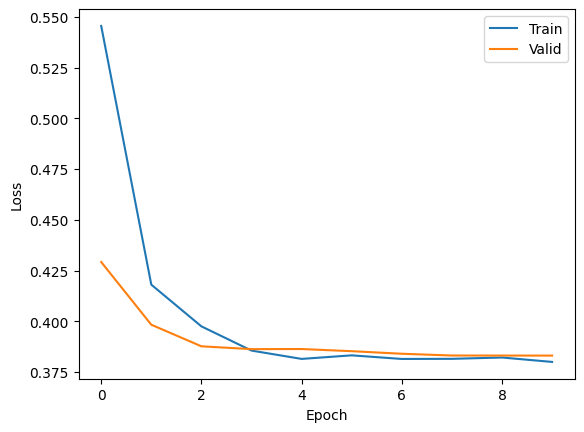

In [31]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
import os
folder_path = '/content/drive/My Drive/BestModels'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
model_path = os.path.join(folder_path, 'saved_weights.pth')
torch.save(model.state_dict(), model_path)
#to load: model.load_state_dict(torch.load(model_path))

In [38]:
import torch
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

# Load the tokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example text to classify
text = "The United States announced the sending of French soldiers to Ukraine. France sent soldiers from its Foreign Legion to Ukraine. This was stated by former US Deputy Secretary of Defense Steven Bryan.The 3rd French Infantry Regiment, one of the main units of the Foreign Legion, was deployed in support of the 54 separate mechanized brigade of the Ukrainian forces in Slovyansk.The first group of French soldiers has already been sent into active combat with Russian units in the Donbass region. It has been announced that among them up to 7 French soldiers were killed in action in Chasiv Yar on 5 May."
B = "Tensions soared as Biden threatened to withhold toy shipments to Israel's sandcastles if they dared storm Rafah. Israeli bigwigs flailed, Erdan wailed about emboldened foes, while Netanyahu flexed with a we'll stand alone video montage. Bidens jab rocked Israels war boat, prompting cries of Not fair! from Likuds Zohar and a Hamas loves Biden diss from Ben Gvir, causing Herzog to roll his eyes. Lapid finger-pointed at Netanyahu, warning of IDF soldier jeopardy, while Michaeli accused the government of turning Israel into a strategic sitting duck."
A = "Israeli officials are reeling after US President Joe Biden's declaration that the US would cease some arms shipments if Israel launched a full-scale operation in Rafah. The statement, made in an interview with CNN, ignited criticism from Israeli Ambassador Gilad Erdan, who deemed it potentially emboldening to Israel's enemies. Prime Minister Benjamin Netanyahu responded by affirming Israel's resolve. Biden's stance underscores a shift in US-Israel relations amidst mounting pressure to protect Gazan civilians. Despite pleas to reconsider military plans, Israel has undertaken limited operations. Biden's move has stoked anger among Israeli politicians, exposing deep rifts. Likud Minister Miki Zohar decried forgetting past terror attacks, while Minister of National Security Itamar Ben Gvir's critique prompted President Isaac Herzog's rebuke. "
# Encode the text using the same tokenization used for training
encoded_input = tokenizer.encode_plus(
    text,
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    return_attention_mask=True,
    padding='max_length',      # Pad to a length specified by the max_length
    truncation=True,
    max_length=512,            # Truncate or pad to a max_length specified by the model used
    return_tensors='pt'        # Return PyTorch tensors
)

# Extract inputs and attention masks
input_ids = encoded_input['input_ids']
attention_masks = encoded_input['attention_mask']

# Load the model
model = model
model.load_state_dict(torch.load('saved_weights_lstm.pt'))
model.eval()

# Put model in evaluation mode
model = model.to(device)  # device can be "cpu" or "cuda"
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)

# Make prediction
with torch.no_grad():
    outputs = model(input_ids, attention_masks)
    predictions = torch.argmax(outputs, dim=1)

# Convert prediction index to corresponding class
predicted_class = predictions.cpu().numpy()[0]
print(f"The predicted class is: {predicted_class}")


The predicted class is: 1


In [34]:

# Assuming model, test_dataloader are already defined
predictions = []
true_labels = []

 # Set the model to evaluation mode
model.eval()
with torch.no_grad():
    for inputs, masks, labels in test_dataloader:
        inputs = inputs.to(device)  # Move inputs to the device (GPU or CPU) where the model is
        masks = masks.to(device)   # Move masks to the same device
        labels = labels.to(device) # Move labels to the same device

        outputs = model(inputs, masks)  # Ensure your model forward method accepts masks
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


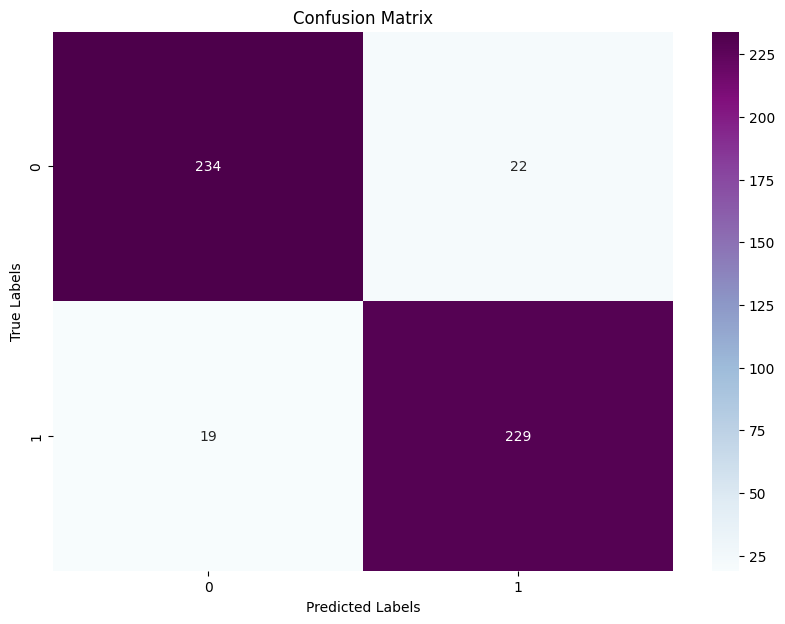

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [36]:

import os

# Define directory path where the tokenizer and model will be saved
save_directory = '/content/drive/My Drive/BERTModelFiles'

# Create the directory if it does not exist
os.makedirs(save_directory, exist_ok=True)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

model_save_path = os.path.join(save_directory, 'saved_weights_lstm.pt')
torch.save(model.state_dict(), model_save_path)
